In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a Rat brain to the Waxholm.  Thus the Waxholm is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

First we'll download the atlas image

In [3]:
"""
refToken = "ara_ccf2"
refImg = imgDownload(refToken)
"""
refImg = imgRead("/cis/project/clarity/data/audrey/WHS_T2star_rsa.img")
refImgOrig = refImg[:,:,:]

Next we'll visuaize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

In [4]:
refThreshold = imgPercentile(refImg, 0.99)
print(refThreshold)

18379.0509804


When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

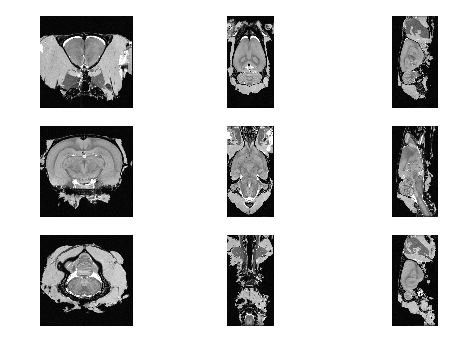

In [5]:
imgShow(refImg, vmax=refThreshold)

Now we download the corresponding annotations

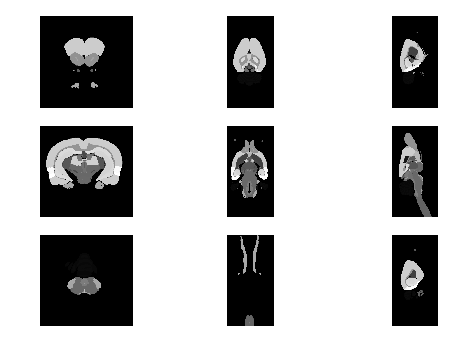

In [6]:
### refAnnoImg = imgDownload(refToken, channel="annotation")
refAnnoImg = imgRead("/cis/project/clarity/data/audrey/WHS_rat_atlas_v2_anno_rsa.img")
refAnnoImgOrig = refAnnoImg[:,:,:]
imgShow(refAnnoImg)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values. Since we always want the backgrond (label 0) to be dark we make the 0th row is [0,0,0].

In [7]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

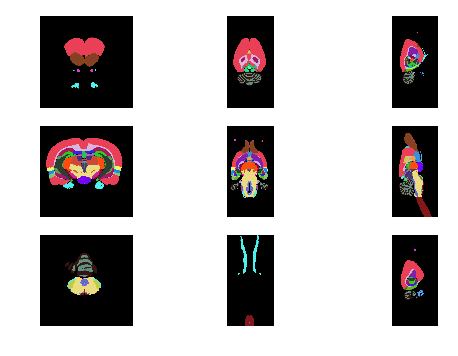

In [8]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

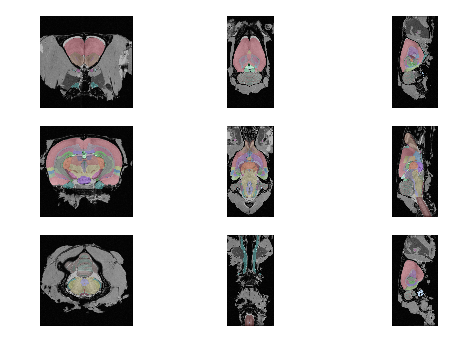

In [9]:
imgShow(refImg, vmax=refThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.3, newFig=False)
plt.show()

## Downloading input image
*ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [10]:
"""
inToken = "Control258"

nd = neurodata()
resolutionList = nd.get_metadata(inToken)['dataset']['voxelres'].keys()
lowestResolution = int(max(resolutionList))
print(lowestResolution)
"""

'\ninToken = "Control258"\n\nnd = neurodata()\nresolutionList = nd.get_metadata(inToken)[\'dataset\'][\'voxelres\'].keys()\nlowestResolution = int(max(resolutionList))\nprint(lowestResolution)\n'

Clearly resolution 5 is the lowest available resolution.  So we'll download the image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [11]:
"""
inImg = imgDownload(inToken, resolution=lowestResolution)
"""
inImg = imgRead("/cis/project/clarity/data/audrey/branch160121SagLeft_ch0_res2.img")

We'll only use intensity values below the 99th percentile in the visualization.

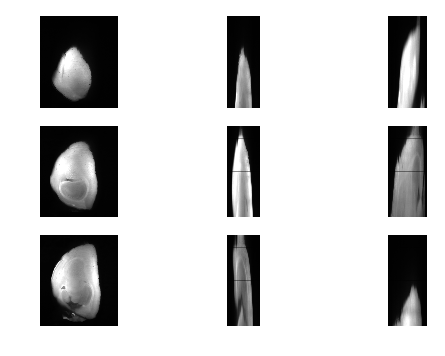

In [12]:
inThreshold = imgPercentile(inImg, 0.99)
imgShow(inImg, vmax=inThreshold)

## Reorienting input image
You may have noticed that the input brain is not oriented in the same way as the atlas.  Let's look at the atlas.

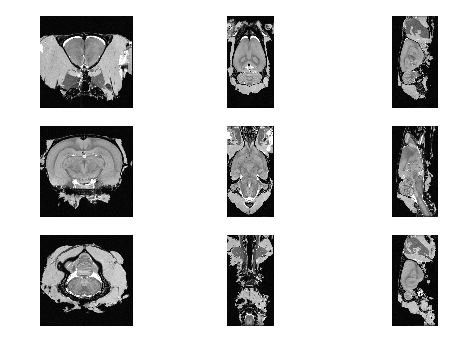

In [13]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the input brain...

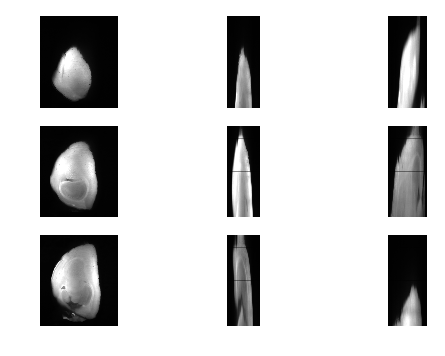

In [14]:
imgShow(inImg, vmax=inThreshold)

...we see that the x-axis goes from **I**nferior to Superior, the y-axis goes from **A**nterior to Posterior and the Z axis goes from **L**eft to Right.  Thus it's in **IAL** orientation.  Therefore we reorient the input image from **IAL** to **RSA**

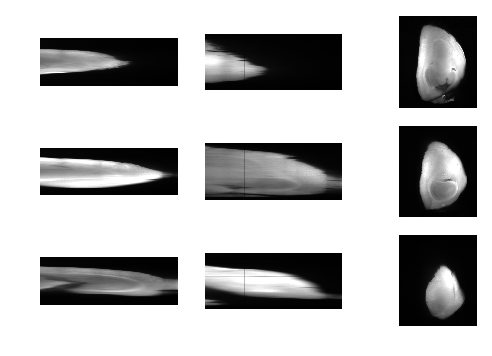

In [15]:
inOrient = "IAL"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [16]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

## Create brain mask of reference image

Our reference image includes tissues outside the brain while our input image does not.  Therefore we need to mask out all regions of the reference image that are not part of the brain.  This can be done easily done using the reference annotations.  First we generate a mask of the brain using non-zero annotation labels.

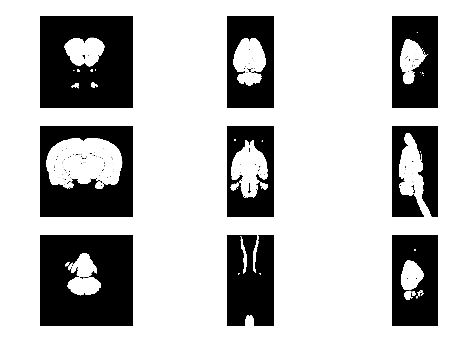

In [17]:
maskImg1 = sitk.BinaryThreshold(refAnnoImg,0,0,0,255) #lowerThreshold, UpperThreshold, insideValue, outsideValue
imgShow(maskImg1, vmax = 255)

Next we create a mask to exclude the trigeminal nerve since (Waxholm label 76) in since it's outside the brain

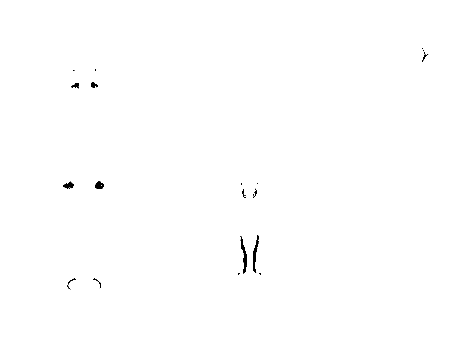

In [18]:
maskImg2 = sitk.BinaryThreshold(refAnnoImg,76,76,0,255) #lowerThreshold, UpperThreshold, insideValue, outsideValue
imgShow(maskImg2, vmax = 255)

Combining these masks

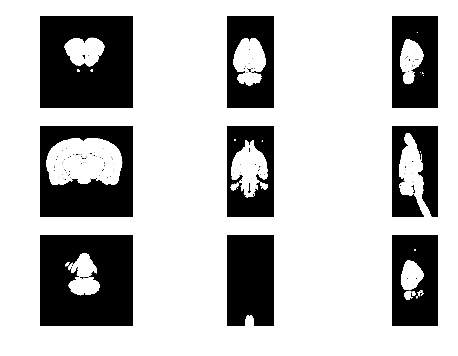

In [19]:
refMaskImg = sitk.Mask(maskImg1, maskImg2)
imgShow(refMaskImg, vmax = 255)

Now we apply the mask to the reference image.

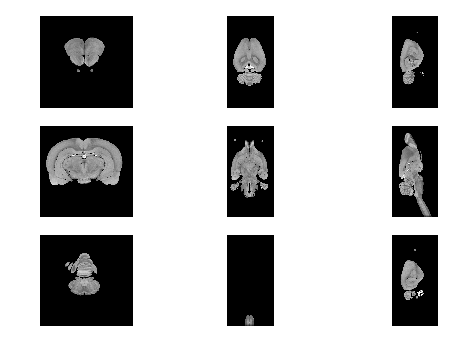

In [20]:
refImg = sitk.Mask(refImg, refMaskImg)
imgShow(refImg, vmax=refThreshold)

## Create and apply two-thirds mask of reference image
Our input image only two-thirds of a the cortex and excludes most of the cerebellum and olfactory bulb.  Therefore we need to exclude these regions from reference image annotations as well.  We do this by creating an empty image of the same size and spacing of the reference image.  We then paste an Region of Interest (ROI) from the reference mask which excludes these regions into the empty image.

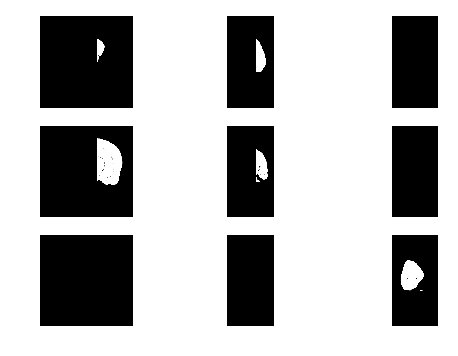

In [21]:
roiStart = [312,67,188]
roiSize = [183,296,447]

emptyImg = sitk.Image(refMaskImg.GetSize(),refMaskImg.GetPixelIDValue()) # Create an empty image
emptyImg.CopyInformation(refMaskImg) # Copy spacing, origin and direction from reference image
refMaskImg = sitk.Paste(emptyImg, refMaskImg, roiSize, roiStart, roiStart)
imgShow(refMaskImg, vmax=255)

Now we apply this mask to the reference image and annotations

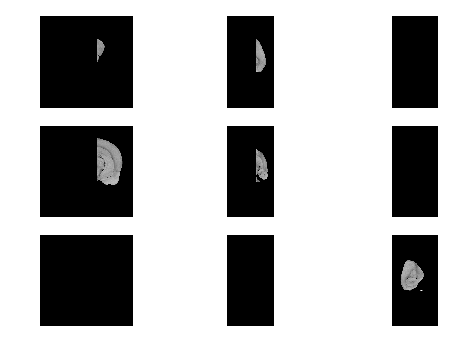

In [22]:
refImg = sitk.Mask(refImg, refMaskImg)
imgShow(refImg, vmax=refThreshold)

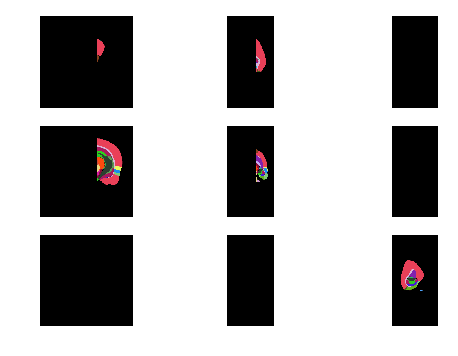

In [23]:
refAnnoImg = sitk.Mask(refAnnoImg, refMaskImg)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

# Affine Registration
We can finally begin the registration. Ideally we would do resgistration at the full scale but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images.

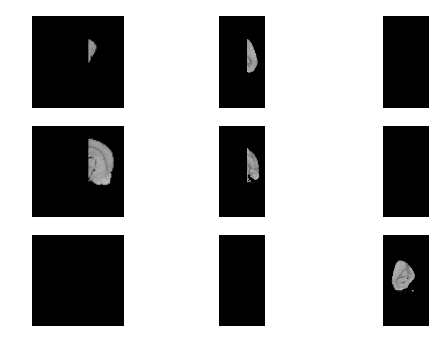

(80, 80, 160)


In [24]:
spacing=[0.25,0.25,0.25]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=refThreshold)
print(refImg_ds.GetSize())

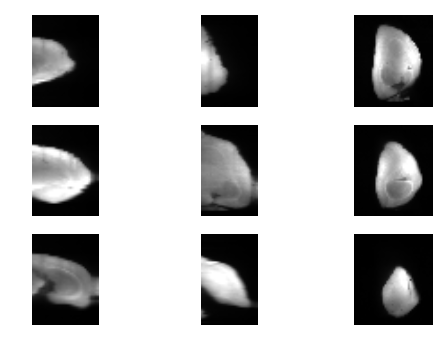

In [25]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=inThreshold)

We will initialize the affine registration using the reference image's region of interest 

In [26]:
translation = -np.array(roiStart)*np.array(refImg.GetSpacing())
inAffine = [1,0,0,0,1,0,0,0,1]+translation.tolist()
print(inAffine)

[1, 0, 0, 0, 1, 0, 0, 0, 1, -12.168000251054764, -2.613000053912401, -7.332000151276588]


Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the input and reference images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [27]:
affine = imgAffineComposite(inImg_ds, refImg_ds, iterations=100, useMI=True, verbose=True, inAffine=inAffine)

Step translation:
0.	 -0.11009232163
1.	 -0.116495837068
2.	 -0.118330945187
3.	 -0.122242109981
4.	 -0.126377978968
5.	 -0.127365701401
6.	 -0.130797271813
7.	 -0.134323081634
8.	 -0.134416564162
9.	 -0.137603369066
10.	 -0.137796919082
11.	 -0.140299717441
12.	 -0.143312284723
13.	 -0.145150544357
14.	 -0.147834082526
15.	 -0.147727236433
16.	 -0.149714719741
17.	 -0.152357550395
18.	 -0.149491900454
19.	 -0.151610210153
20.	 -0.151232676274
21.	 -0.152509470335
22.	 -0.15452392903
23.	 -0.153500003067
24.	 -0.155088101131
25.	 -0.154441148789
26.	 -0.155254118348
27.	 -0.157020850718
28.	 -0.155949563855
29.	 -0.157171759248
30.	 -0.15650517229
31.	 -0.156918040874
32.	 -0.158419282766
33.	 -0.157477355835
34.	 -0.158442094779
35.	 -0.158069130897
36.	 -0.158398489061
37.	 -0.159572842319
38.	 -0.15886639771
39.	 -0.159447063429
40.	 -0.160220456896
41.	 -0.159306829193
42.	 -0.159474403407
43.	 -0.159384568031
44.	 -0.159663066969
45.	 -0.16008403501
46.	 -0.16013236178
47.	 -0.160

Now we apply the affine transform to the input image and mask

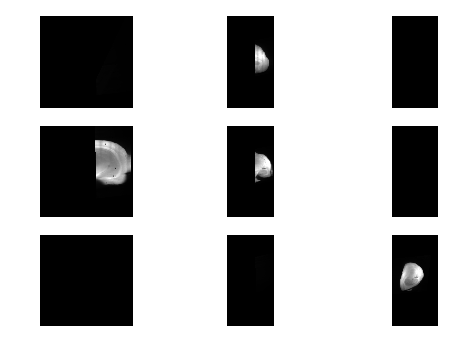

In [28]:
inImg = imgApplyAffine(inImg, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg, vmax=inThreshold)

We can evaluate the affine registration by generating a checkerboard of the reference and input images.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

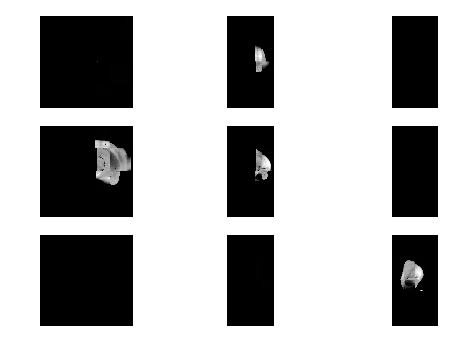

In [29]:
imgShow(imgChecker(inImg, refImg), vmax=refThreshold)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference Waxholm have very differnt intensity profiles.

In [35]:
inImg_ds = imgResample(inImg, spacing=spacing)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, alphaList=[0.05,0.02,0.01],
                                              scaleList = [0.5,0.5,0.5], useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-8.5559e+10, 5.5386, 0, -8.5559e+10 (99.3196%), 1.100000e-03
E = -8.5559e+10 (99.3196%)
Length = 3.29053
Time = 51.3286s (0.855477m)

Step 1: alpha=0.02, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-8.63463e+10, 10.4748, 0, -8.63463e+10 (98.9797%), 1.100000e-03
1.	-8.64491e+10, 97.0269, 0, -8.64491e+10 (98.8471%), 1.210000e-03
2.	-8.74559e+10, 141.153, 0, -8.74559e+10 (97.5474%), 1.331000e-03
3.	-8.84112e+10, 214.898, 0, -8.84112e+10 (96.314%), 1.464100e-03
4.	-8.95655e+10, 326.418, 0, -8.95655e+10 (94.8238%), 1.610510e-03
5.	-9.05626e+10, 489.881, 0, -9.05626e+10 (93.5367%), 1.771561e-03
6.	-9.17006e+10, 698.24, 0, -9.17006e+10 (92.0674%), 1.948717e-03
7.	-9.25828e+10, 979.097, 0, -9.25828e+10 (90.9286%), 2.143589e-03
8.	-9.37064e+10, 1341.06, 0, -9.37064e+10 (89.478%), 2.357948e-03
9.	-9.48983e+10, 1891.73, 0, -9.48983e+10 (87.9393%), 2.593742e-

In [32]:
imgWrite(inImg_ds, "/cis/project/clarity/data/audrey/in_ds.img")
imgWrite(refImg_ds, "/cis/project/clarity/data/audrey/ref_ds.img")

Now we apply the displacement field

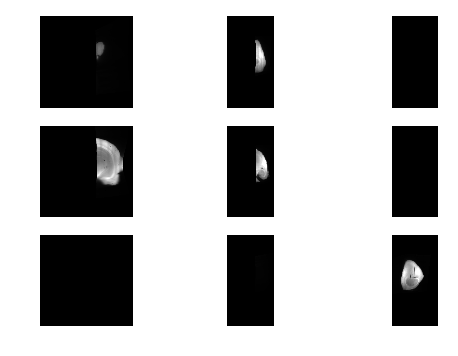

In [36]:
inImg2 = imgApplyField(inImg, field, size=refImg.GetSize())
imgShow(inImg2, vmax=inThreshold)

### Evaluation using checker board
We can evaluate the deformable registration using a checkerboard image

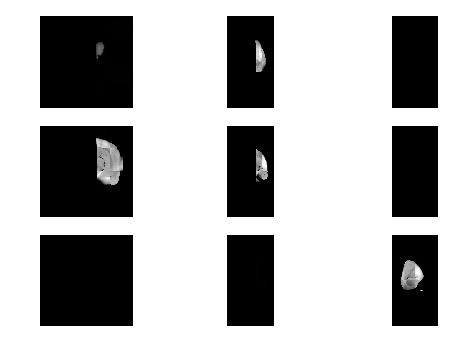

In [37]:
imgShow(imgChecker(inImg2, refImg, useHM=True), vmax=refThreshold)

### Evaluation using annoatations
We can also evaluate the registration by overlaying the Waxholm annotations over the deformed input image.

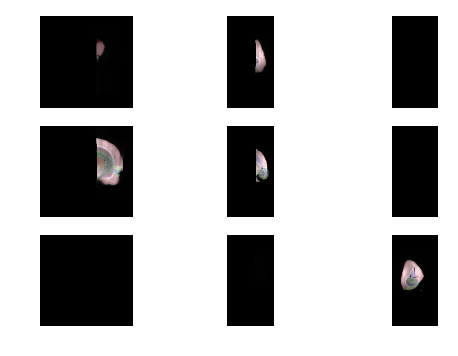

In [38]:
imgShow(inImg2, vmax=inThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

In [39]:
imgWrite(refAnnoImg,"/cis/project/clarity/data/audrey/outAnno.img")
imgWrite(inImg2,"/cis/project/clarity/data/audrey/out.img")

## Uploading Results

### Uploading deformed input image
We can now upload the Waxholm-aligned input brain back into ndstore.

In [40]:
### token = "AutA_to_ara3"
### imgUpload(inImg, token)

### Uploading deformed atlas annotations

In [41]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the Waxholm annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the Waxholm space to the space before registration.

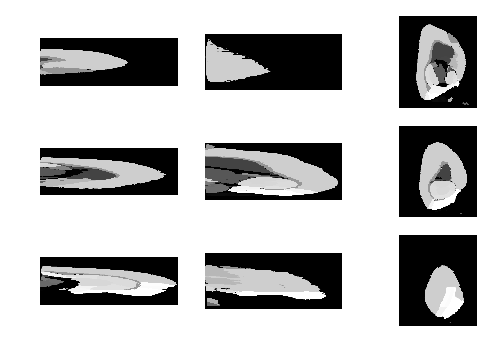

In [42]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=inImgSpacing_reorient)
inAnnoThreshold = imgPercentile(inAnnoImg,0.99)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

Were not done yet.  We still need to reorient these annotations to their original  

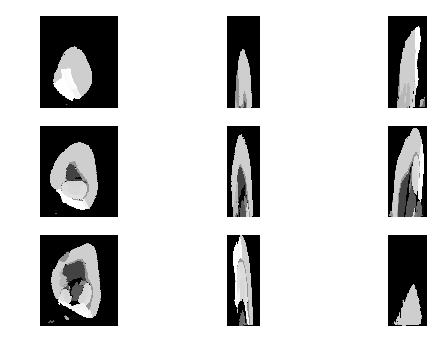

In [43]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

In [44]:
imgWrite(inAnnoImg,"/cis/project/clarity/data/audrey/inAnno.img")

We can upload these annotations at the lowest possible resolution.

In [ ]:
outToken = "ara3_to_AutA"
outChannel = "annotation_draft"
imgUpload(inAnnoImg, outToken, outChannel, resolution=5)